In [193]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
  

"""
fe : ratio of ethanol 
fpg : ratio of PG
Cm : experimental data of solubiluty in mixter based on ratio
Cw : solubility in pure water
Cpg : solubility in pure PG
Ce : solubility in pure ethanol
T : temperature
LCm,LCe, ... : log of Cm, ...

x , y : for finding j with regression

Sm : prediction data of solubility 
LSm : prediction data of log Sm

"""

'\nfe : ratio of ethanol \nfpg : ratio of PG\nCm : experimental data of solubiluty in mixter based on ratio\nCw : solubility in pure water\nCpg : solubility in pure PG\nCe : solubility in pure ethanol\nT : temperature\nLCm,LCe, ... : log of Cm, ...\n\nx , y : for finding j with regression\n\nSm : prediction data of solubility \nLSm : prediction data of log Sm\n\n'

In [224]:
# function for change molar to mole fraction
# density of solvent
de = 0.785
dw = 0.997
dpg = 1.0273
    # solvent Molecular weight
mw_w = 18
mw_e = 46
mw_pg = 76.09
def Mole_fraction (M, d1, d2, mw_1, mw_2 ):
    if len(M) == 7 :
        f1 = [1,0.8,0.6,0.5,0.4,0.2,0]
        f2 = [0,0.2,0.4,0.5,0.6,0.8,1]
        f1 = np.array(f1).reshape(-1,1)
        f2= np .array(f2).reshape(-1,1)
    else:
        f1 = np.arange(0,1.01, 0.01)
        f2 = 1-f1
    
    mol_1 = (f1*d1)/mw_1
    mol_2 = (f2*d2)/mw_2
    X2 = mol_2/(mol_2+mol_1)
    X1 = mol_1/(mol_2+mol_1)
    MW = X2*mw_2 + X1*mw_1
    d = (f1*d1) + (f2*d2)
    m = (M/(1000*d))*MW
    Xe = m/(m+1)
    return (Xe, MW, d)
    #print('exp mole fraction = ' , Xe)


    
    
#   jouyban-Acree function for binary mixtures

def Jouyban_Acree (Cm, C1, C2, d1, d2):
    F1 = [1,0.8,0.6,0.5,0.4,0.2,0]
    F2 = [0,0.2,0.4,0.5,0.6,0.8,1]
    F1 = np.array(F1).reshape(-1,1)
    F2= np .array(F2).reshape(-1,1)
    # change v/v to w/w
    W1 = F1*d1
    W2 = F2*d2
    f1 = W1/(W2+W1)
    f2 = W2/(W2+W1)
    
    LCm = [math.log10(x) for x in Cm]
    LC1 = math.log10(C1)
    LC2 = math.log10(C2)
    LCm = np.array(LCm).reshape(-1,1)

    x = LCm - (f1 * LC1 + f2 * LC2) 
    y0 = (f1 * f2)/T
    y1 = (f1*f2*(f1-f2))/T
    y2 = (f1*f2*(f1-f2)*(f1-f2))/T

    reg0 = LinearRegression().fit(y0,x)
    reg1 = LinearRegression().fit(y1,x)
    reg2 = LinearRegression().fit(y2,x)

    j0 = float(reg0.coef_)
    j1 = float(reg1.coef_)
    j2 = float(reg2.coef_)
    #print('j0 = ',j0 , '\n' ,'j1 = ',j1 , '\n' , 'j2 = ',j2)
    f12 = np.arange(0,1.01, 0.01)
    f22 = 1-f12

    LSm = (f12 * LC1) + (f22 * LC2) + (f12*f22/T)*(j0 + (j1 * (f12-f22)) + (j2*(f12-f22)*(f12-f22)))
    Sm = 10**LSm
    #print (Sm)
    return (Sm)

    
    
    
####  EHSA function for binary mixture

def EHSA (exp_data, T_fusion, dH_fusion, D_SP, D_V, sp1, sp2, d1, d2, mw_1, mw_2):
    
    Xe, MW, d = Mole_fraction(exp_data, d1, d2, mw_1, mw_2)
    f1 = [1,0.8,0.6,0.5,0.4,0.2,0]
    f2 = [0,0.2,0.4,0.5,0.6,0.8,1]
    f1 = np.array(f1).reshape(-1,1)
    f2= np .array(f2).reshape(-1,1)
    
    spmix = (f1*sp1) + (f2*sp2)
    
    # T0 : heat fusion temp
    T0 = T_fusion
    # dF : heat of fusion cal/mole
    dHf = dH_fusion
    # sp = drug Solubilitty parameter (cal/cm3)^0.5
    sp = D_SP
    # V2 = drug molar volume (cm3/mole)
    V2 = D_V
    
    # solvent molar volume (cm3/mole)
    V1 =  MW/d
    
    # volume fraction
    Q = 1
    #Q = (V1*(1-Xe))/((V1*(1-Xe)) + V2*Xe)
    #print ('Q', Q)
    
    # A coeficent
    A = (V2*Q)/(R*T)

    LXi = (dHf/(2.303*R*T)) * ((T0-T)/T0)
    #LXi = (dHf/(2.303*R*T)) * (math.log10(T0/T))
    Xi = 10**(-LXi)
    # ideal solubility
    # calculate the W_exp
    W = ((np.log10(Xi/Xe)/A) + sp**2 + spmix**2)*0.5
    
    #### polynomial regression for EHSA ####
    # Importing the dataset
    ## x = data, y = quadratic equation
    x = spmix
    x1 = x.reshape(-1, 1)
    y = W
    '''
    plt.scatter(x, y, s = 10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Non Linear Data')

    '''
    poly_features = PolynomialFeatures(degree = 2, include_bias = False)
    x_poly = poly_features.fit_transform(x1)
    lin_reg = LinearRegression()
    lin_reg.fit(x_poly, y)
    #print('Coefficients of x are', lin_reg.coef_)
    #print('Intercept is', lin_reg.intercept_)

    y_deg2 = lin_reg.predict(x_poly)
    # model evaluation
    mse_deg2 = mean_squared_error(y, y_deg2)

    r2_deg2 = r2_score(y, y_deg2)

    # printing values
    #print('MSE of Polyregression model', mse_deg2)
    #print('R2 score of Linear model: ', r2_deg2)

    # calculation of W_calc , X_calc
    Q2 = 1
    f12 = np.arange(0,1.01, 0.01)
    f22 = 1-f12
    spmix2 = (f22*sp2) + (f12*sp1)

    A2 = (V2*Q2)/(R*T)
    mol_2 = (f22*d2)/mw_2
    mol_1 = (f12*d1)/mw_1
    X2 = mol_2/(mol_2+mol_1)
    X1 = mol_1/(mol_2+mol_1)
    MW = X2*mw_2 + X1*mw_1
    d = (f22*d2) + (f12*d1)
    V1 =  MW/d

    for i in range (1):
        Q3 = Q2
        W_calc =  lin_reg.intercept_[0] + (spmix2 * lin_reg.coef_[0][0]) + ((spmix2**2)* lin_reg.coef_[0][1]) 

        LX_calc = LXi - A2*((sp**2) + (spmix2**2) - (2 * W_calc))

        X_calc = 10**-LX_calc

        #X_calc = np.array(X_calc).reshape(-1,1)

        Q2 = (V1*(1-X_calc))/((V1*(1-X_calc)) + V2*X_calc)
        A2 = (V2*Q2)/(R*T)


    #print ('Q2', Q2)
    #print ('A2', A2)
    #print("W_calc =", lin_reg.intercept_[0], '+' ,  lin_reg.coef_[0][0], "*S"  , "+" , lin_reg.coef_[0][1],  "*S^2 ")

    #print ('W_exp =' , W)
    #print ("W_calc =", W_calc)
    #print ('X_calc = ',X_calc )
    return (X_calc, spmix, spmix2)






    
    

In [225]:
####### Diclofenac sodium at 25c


Cw = 0.067
Ce = 0.737
Cpg = 2.060


# density of solvent
de = 0.785
dw = 0.997
dpg = 1.0273
    # solvent Molecular weight
mw_w = 18
mw_e = 46
mw_pg = 76.09


# spE = ethanol Solubilitty parameter (cal/cm3)^0.5
spE = 13.0
# spW = water Solubilitty parameter (cal/cm3)^0.5
spW = 23.4
# spPG = PG Solubilitty parameter (cal/cm3)^0.5
spPG = 14.8


T = 298
R = 1.987

# T0 : heat fusion temp
T0 = 454.2 
# dF : heat of fusion cal/mole
dHf = 9416.826
# sp = drug Solubilitty parameter (cal/cm3)^0.5
sp = 14.59
# V2 = molar volume (cm3/mole)
V2 = 443.08


##### Diclofenac sodium W/E at 25c

Cm_WE = [0.067,0.093,0.292,0.480,0.527,0.655,0.737]
Cm_WE = np.array(Cm_WE).reshape(-1,1)


Cm_WE_D, MW, d = Mole_fraction(Cm_WE, dw, de, mw_w, mw_e)
## jouyban_acree model
Sm_WE = Jouyban_Acree(Cm_WE, Cw, Ce, dw, de)
J_WE_D, MW, d = Mole_fraction(Sm_WE, dw, de, mw_w, mw_e)

## EHSA model
H_WE_D, spmix_WE, spmix2_WE = EHSA (Cm_WE , T0 , dHf , sp , V2, spW, spE, dw, de, mw_w, mw_e)





##### Diclofenac sodium W/PG at 25c

Cm_WPG = [0.067,0.094,0.291,0.501,0.920,1.900,2.060]
Cm_WPG = np.array(Cm_WPG).reshape(-1,1)


Cm_WPG_D, MW, d = Mole_fraction(Cm_WPG, dw, dpg, mw_w, mw_pg)

## jouyban_acree model
Sm_WPG = Jouyban_Acree(Cm_WPG, Cw, Cpg, dw, dpg)
J_WPG_D, MW, d = Mole_fraction(Sm_WPG, dw, dpg, mw_w, mw_pg)

## EHSA model
H_WPG_D, spmix_WPG, spmix2_WPG = EHSA (Cm_WPG , T0 , dHf , sp , V2, spW, spPG, dw, dpg, mw_w, mw_pg)









##### Diclofenac sodium E/PG at 25c

Cm_EPG = [0.737,1.494,1.960,2.157,2.165,2.20,2.060]
Cm_EPG = np.array(Cm_EPG).reshape(-1,1)


Cm_EPG_D, MW, d = Mole_fraction(Cm_EPG, de, dpg, mw_e, mw_pg)

## jouyban_acree model
Sm_EPG = Jouyban_Acree(Cm_EPG, Ce, Cpg, de, dpg)
J_EPG_D, MW, d = Mole_fraction(Sm_EPG, de, dpg, mw_e, mw_pg)

## EHSA model
H_EPG_D, spmix_EPG, spmix2_EPG = EHSA (Cm_EPG , T0 , dHf , sp , V2, spE, spPG, de, dpg, mw_e, mw_pg)




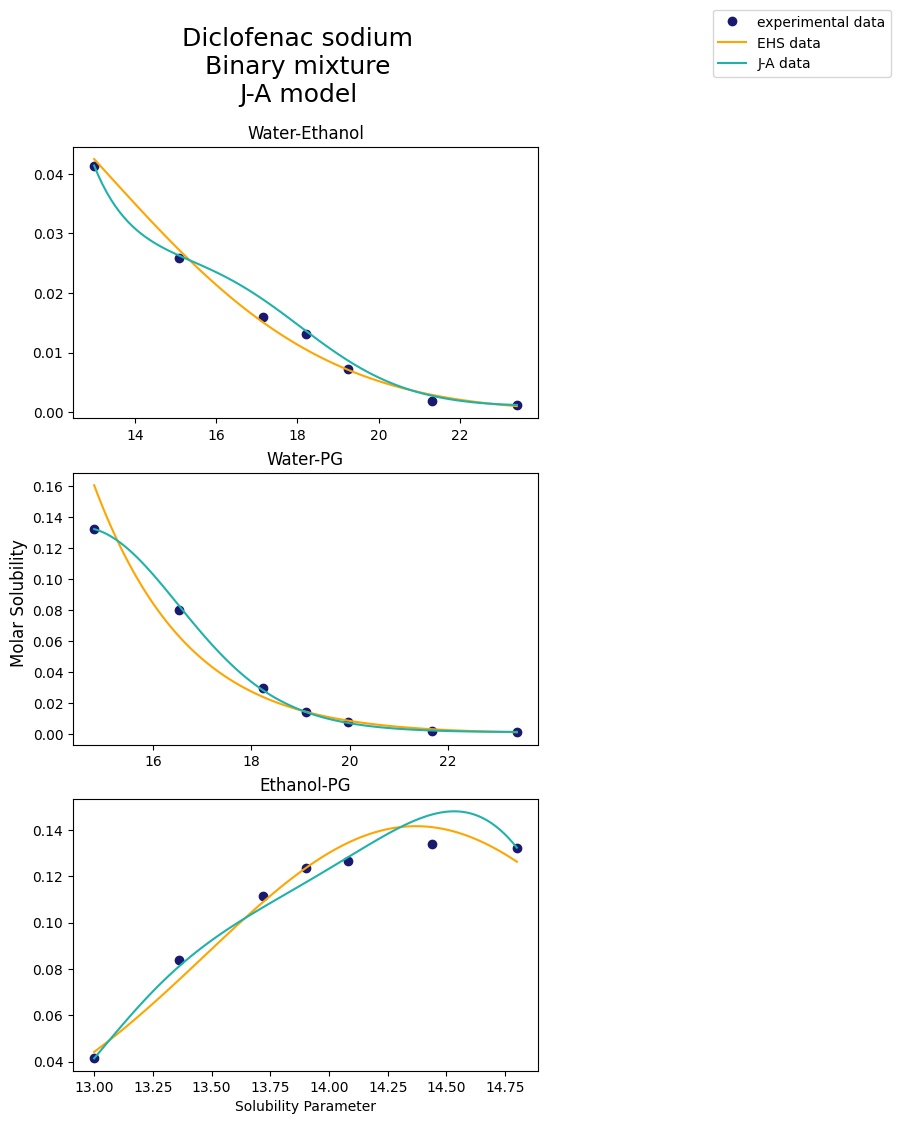

In [226]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=False , sharey=False, layout= None)
fig.suptitle('Diclofenac sodium'+ '\n' + 'Binary mixture'+ '\n' + 'J-A model' , fontsize = 18)
plt.xlabel("Solubility Parameter")

axs[0].set_title("Water-Ethanol")

axs[0].plot(spmix_WE, Cm_WE_D,"o", color= 'midnightblue' , label = "experimental data")
axs[0].plot(spmix2_WE, H_WE_D, color = 'orange' , label = "EHS data"  )
axs[0].plot(spmix2_WE, J_WE_D, color = 'lightseagreen'  , label = "J-A data", )


fig.legend( bbox_to_anchor=(1.5, 1))

axs[1].set_title("Water-PG")

axs[1].plot(spmix_WPG, Cm_WPG_D,"o", color= 'midnightblue' , label = "experimental data")
axs[1].plot(spmix2_WPG, H_WPG_D, color = 'orange' , label = "EHS data"  )
axs[1].plot(spmix2_WPG, J_WPG_D, color = 'lightseagreen'  , label = "J-A data", )


axs[2].set_title("Ethanol-PG")

axs[2].plot(spmix_EPG, Cm_EPG_D,"o", color= 'midnightblue' , label = "experimental data")
axs[2].plot(spmix2_EPG, H_EPG_D, color = 'orange' , label = "EHS data"  )
axs[2].plot(spmix2_EPG, J_EPG_D, color = 'lightseagreen'  , label = "J-A data", )


fig.supylabel("Molar Solubility")
#fig.supxlabel("Solubility Parameter")

plt.show()





In [227]:
####### Ketoconazole at 25c


Cw = 0.0000242
Ce = 0.0916719
Cpg = 0.0490821


# density of solvent
de = 0.785
dw = 0.997
dpg = 1.0273
    # solvent Molecular weight
mw_w = 18
mw_e = 46
mw_pg = 76.09


# spE = ethanol Solubilitty parameter (cal/cm3)^0.5
spE = 13.0
# spW = water Solubilitty parameter (cal/cm3)^0.5
spW = 23.4
# spPG = PG Solubilitty parameter (cal/cm3)^0.5
spPG = 14.8


T = 298
R = 1.987

# T0 : heat fusion temp
T0 = 419.92 
# dF : heat of fusion cal/mole
dHf = 13668.38
# sp = drug Solubilitty parameter (cal/cm3)^0.5
sp = 12.42
# V2 = molar volume (cm3/mole)
V2 = 667.66


##### Diclofenac sodium W/E at 25c

Cm_WE = [0.0000242,0.0001814,0.0026413,0.0071229,0.0197629,0.0808348,0.0916719]
Cm_WE = np.array(Cm_WE).reshape(-1,1)


Cm_WE_K, MW, d = Mole_fraction(Cm_WE, dw, de, mw_w, mw_e)
## jouyban_acree model
Sm_WE = Jouyban_Acree(Cm_WE, Cw, Ce, dw, de)
J_WE_K, MW, d = Mole_fraction(Sm_WE, dw, de, mw_w, mw_e)

## EHSA model
H_WE_K, spmix_WE, spmix2_WE = EHSA (Cm_WE , T0 , dHf , sp , V2, spW, spE, dw, de, mw_w, mw_e)





##### Ketoconazole  W/PG at 25c

Cm_WPG = [0.0000242,0.0004406,0.0013704,0.0016413,0.0034196,0.0170536,0.0490821]
Cm_WPG = np.array(Cm_WPG).reshape(-1,1)


Cm_WPG_K, MW, d = Mole_fraction(Cm_WPG, dw, dpg, mw_w, mw_pg)

## jouyban_acree model
Sm_WPG = Jouyban_Acree(Cm_WPG, Cw, Cpg, dw, dpg)
J_WPG_K, MW, d = Mole_fraction(Sm_WPG, dw, dpg, mw_w, mw_pg)

## EHSA model
H_WPG_K, spmix_WPG, spmix2_WPG = EHSA (Cm_WPG , T0 , dHf , sp , V2, spW, spPG, dw, dpg, mw_w, mw_pg)









##### Ketoconazole  E/PG at 25c

Cm_EPG = [0.091672,0.090933,0.089948,0.084283,0.080834,0.063860,0.049082]
Cm_EPG = np.array(Cm_EPG).reshape(-1,1)


Cm_EPG_K, MW, d = Mole_fraction(Cm_EPG, de, dpg, mw_e, mw_pg)

## jouyban_acree model
Sm_EPG = Jouyban_Acree(Cm_EPG, Ce, Cpg, de, dpg)
J_EPG_K, MW, d = Mole_fraction(Sm_EPG, de, dpg, mw_e, mw_pg)

## EHSA model
H_EPG_K, spmix_EPG, spmix2_EPG = EHSA (Cm_EPG , T0 , dHf , sp , V2, spE, spPG, de, dpg, mw_e, mw_pg)




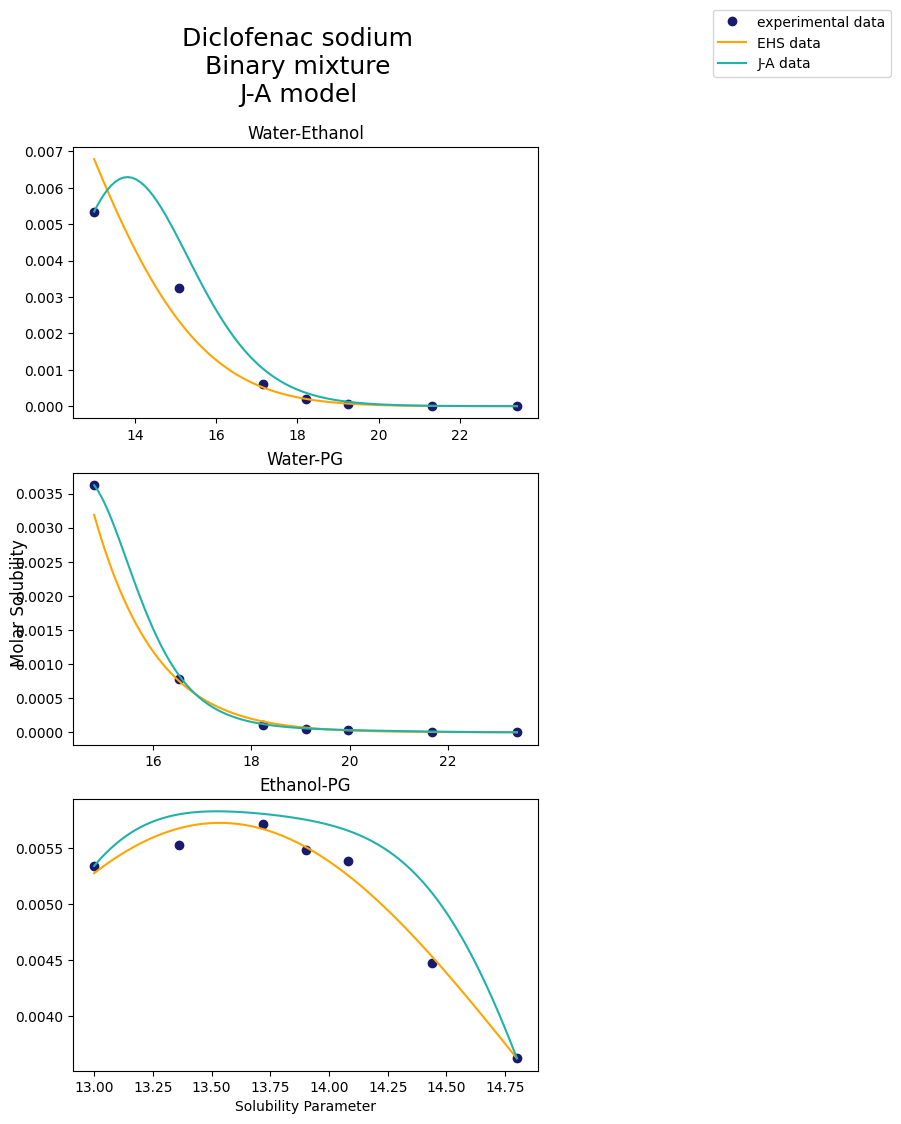

In [228]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=False , sharey=False, layout= None)
fig.suptitle('Diclofenac sodium'+ '\n' + 'Binary mixture'+ '\n' + 'J-A model' , fontsize = 18)
plt.xlabel("Solubility Parameter")

axs[0].set_title("Water-Ethanol")

axs[0].plot(spmix_WE, Cm_WE_K,"o", color= 'midnightblue' , label = "experimental data")
axs[0].plot(spmix2_WE, H_WE_K, color = 'orange' , label = "EHS data"  )
axs[0].plot(spmix2_WE, J_WE_K, color = 'lightseagreen'  , label = "J-A data", )


fig.legend( bbox_to_anchor=(1.5, 1))

axs[1].set_title("Water-PG")

axs[1].plot(spmix_WPG, Cm_WPG_K,"o", color= 'midnightblue' , label = "experimental data")
axs[1].plot(spmix2_WPG, H_WPG_K, color = 'orange' , label = "EHS data"  )
axs[1].plot(spmix2_WPG, J_WPG_K, color = 'lightseagreen'  , label = "J-A data", )


axs[2].set_title("Ethanol-PG")

axs[2].plot(spmix_EPG, Cm_EPG_K,"o", color= 'midnightblue' , label = "experimental data")
axs[2].plot(spmix2_EPG, H_EPG_K, color = 'orange' , label = "EHS data"  )
axs[2].plot(spmix2_EPG, J_EPG_K, color = 'lightseagreen'  , label = "J-A data", )


fig.supylabel("Molar Solubility")
#fig.supxlabel("Solubility Parameter")

plt.show()





In [229]:
####### Lamotrigine at 25c


Cw = 0.000719419
Ce = 0.033340367
Cpg = 0.113777542


# density of solvent
de = 0.785
dw = 0.997
dpg = 1.0273
# solvent Molecular weight
mw_w = 18
mw_e = 46
mw_pg = 76.09


# spE = ethanol Solubilitty parameter (cal/cm3)^0.5
spE = 13.0
# spW = water Solubilitty parameter (cal/cm3)^0.5
spW = 23.4
# spPG = PG Solubilitty parameter (cal/cm3)^0.5
spPG = 14.8


T = 298
R = 1.987

# T0 : heat fusion temp
T0 = 491.01 
# dF : heat of fusion cal/mole
dHf = 9328.394
# sp = drug Solubilitty parameter (cal/cm3)^0.5
sp = 15.58
# V2 = molar volume (cm3/mole)
V2 = 162.91



##### Lamotrigine  W/E at 25c

Cm_WE = [0.000719419,0.002782587,0.012301806,0.022609449,0.037811583,0.05927342,0.033340367]
Cm_WE = np.array(Cm_WE).reshape(-1,1)


Cm_WE_L, MW, d = Mole_fraction(Cm_WE, dw, de, mw_w, mw_e)
## jouyban_acree model
Sm_WE = Jouyban_Acree(Cm_WE, Cw, Ce, dw, de)
J_WE_L, MW, d = Mole_fraction(Sm_WE, dw, de, mw_w, mw_e)

## EHSA model
H_WE_L, spmix_WE, spmix2_WE = EHSA (Cm_WE , T0 , dHf , sp , V2, spW, spE, dw, de, mw_w, mw_e)





##### Lamotrigine  W/PG at 25c

Cm_WPG = [0.000719419,0.003006148,0.009787492,0.016296092,0.033042286,0.120037245,0.113777542]

Cm_WPG = np.array(Cm_WPG).reshape(-1,1)


Cm_WPG_L, MW, d = Mole_fraction(Cm_WPG, dw, dpg, mw_w, mw_pg)

## jouyban_acree model
Sm_WPG = Jouyban_Acree(Cm_WPG, Cw, Cpg, dw, dpg)
J_WPG_L, MW, d = Mole_fraction(Sm_WPG, dw, dpg, mw_w, mw_pg)

## EHSA model
H_WPG_L, spmix_WPG, spmix2_WPG = EHSA (Cm_WPG , T0 , dHf , sp , V2, spW, spPG, dw, dpg, mw_w, mw_pg)









##### Lamotrigine E/PG at 25c

Cm_EPG = [0.033340367,0.062209518,0.109604407,0.154614648,0.187999727,0.259106965,0.113777542]

Cm_EPG = np.array(Cm_EPG).reshape(-1,1)


Cm_EPG_L, MW, d = Mole_fraction(Cm_EPG, de, dpg, mw_e, mw_pg)

## jouyban_acree model
Sm_EPG = Jouyban_Acree(Cm_EPG, Ce, Cpg, de, dpg)
J_EPG_L, MW, d = Mole_fraction(Sm_EPG, de, dpg, mw_e, mw_pg)

## EHSA model
H_EPG_L, spmix_EPG, spmix2_EPG = EHSA (Cm_EPG , T0 , dHf , sp , V2, spE, spPG, de, dpg, mw_e, mw_pg)




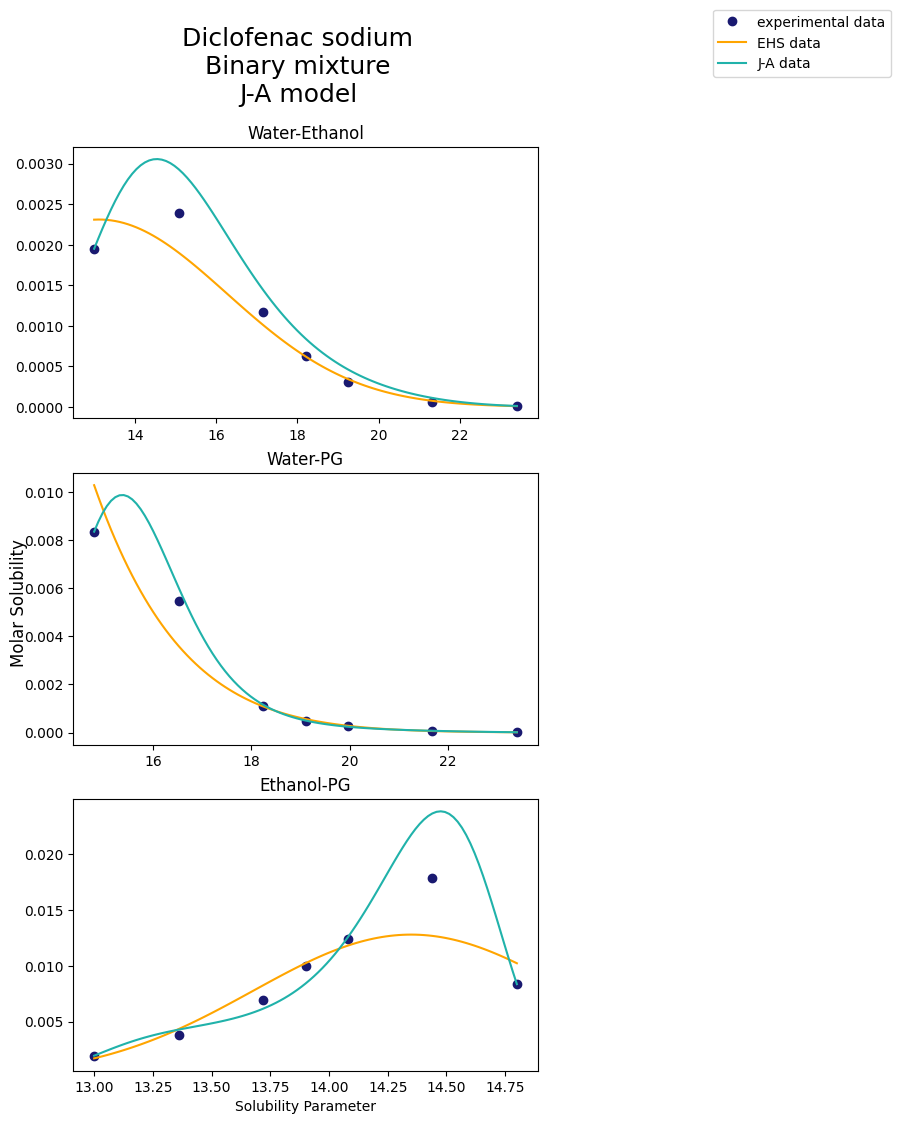

In [230]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=False , sharey=False, layout= None)
fig.suptitle('Diclofenac sodium'+ '\n' + 'Binary mixture'+ '\n' + 'J-A model' , fontsize = 18)
plt.xlabel("Solubility Parameter")

axs[0].set_title("Water-Ethanol")

axs[0].plot(spmix_WE, Cm_WE_L,"o", color= 'midnightblue' , label = "experimental data")
axs[0].plot(spmix2_WE, H_WE_L, color = 'orange' , label = "EHS data"  )
axs[0].plot(spmix2_WE, J_WE_L, color = 'lightseagreen'  , label = "J-A data", )


fig.legend( bbox_to_anchor=(1.5, 1))

axs[1].set_title("Water-PG")

axs[1].plot(spmix_WPG, Cm_WPG_L,"o", color= 'midnightblue' , label = "experimental data")
axs[1].plot(spmix2_WPG, H_WPG_L, color = 'orange' , label = "EHS data"  )
axs[1].plot(spmix2_WPG, J_WPG_L, color = 'lightseagreen'  , label = "J-A data", )


axs[2].set_title("Ethanol-PG")

axs[2].plot(spmix_EPG, Cm_EPG_L,"o", color= 'midnightblue' , label = "experimental data")
axs[2].plot(spmix2_EPG, H_EPG_L, color = 'orange' , label = "EHS data"  )
axs[2].plot(spmix2_EPG, J_EPG_L, color = 'lightseagreen'  , label = "J-A data", )


fig.supylabel("Molar Solubility")
#fig.supxlabel("Solubility Parameter")

plt.show()





In [231]:
####### Theophylline at 25c


Cw = 0.042905934
Ce = 0.045226428
Cpg = 0.072144159


# density of solvent
de = 0.785
dw = 0.997
dpg = 1.0273
# solvent Molecular weight
mw_w = 18
mw_e = 46
mw_pg = 76.09


# spE = ethanol Solubilitty parameter (cal/cm3)^0.5
spE = 13.0
# spW = water Solubilitty parameter (cal/cm3)^0.5
spW = 23.4
# spPG = PG Solubilitty parameter (cal/cm3)^0.5
spPG = 14.8


T = 298
R = 1.987

# T0 : heat fusion temp
#T0 = 546.8 
T0 = 543.7
# dF : heat of fusion cal/mole
#dHf = 4541.11
dHf = 7456.979 

# sp = drug Solubilitty parameter (cal/cm3)^0.5
sp = 14 
# V2 = molar volume (cm3/mole)
V2 = 122.97



##### Theophylline  W/E at 25c

Cm_WE = [0.042905934,0.073768505,0.128764213,0.14918456,0.175406142,0.136189793,0.045226428]
Cm_WE = np.array(Cm_WE).reshape(-1,1)


Cm_WE_T, MW, d = Mole_fraction(Cm_WE, dw, de, mw_w, mw_e)
## jouyban_acree model
Sm_WE = Jouyban_Acree(Cm_WE, Cw, Ce, dw, de)
J_WE_T, MW, d = Mole_fraction(Sm_WE, dw, de, mw_w, mw_e)

## EHSA model
H_WE_T, spmix_WE, spmix2_WE = EHSA (Cm_WE , T0 , dHf , sp , V2, spW, spE, dw, de, mw_w, mw_e)





##### Theophylline  W/PG at 25c

Cm_WPG = [0.042905934,0.055204552,0.085138925,0.091845153,0.115978291,0.127116662,0.072144159]

Cm_WPG = np.array(Cm_WPG).reshape(-1,1)


Cm_WPG_T, MW, d = Mole_fraction(Cm_WPG, dw, dpg, mw_w, mw_pg)

## jouyban_acree model
Sm_WPG = Jouyban_Acree(Cm_WPG, Cw, Cpg, dw, dpg)
J_WPG_T, MW, d = Mole_fraction(Sm_WPG, dw, dpg, mw_w, mw_pg)

## EHSA model
H_WPG_T, spmix_WPG, spmix2_WPG = EHSA (Cm_WPG , T0 , dHf , sp , V2, spW, spPG, dw, dpg, mw_w, mw_pg)









##### Theophylline  E/PG at 25c

Cm_EPG = [0.045226428,0.061933985,0.068663418,0.073768505,0.078409493,0.076321048,0.072144159]


Cm_EPG = np.array(Cm_EPG).reshape(-1,1)


Cm_EPG_T, MW, d = Mole_fraction(Cm_EPG, de, dpg, mw_e, mw_pg)

## jouyban_acree model
Sm_EPG = Jouyban_Acree(Cm_EPG, Ce, Cpg, de, dpg)
J_EPG_T, MW, d = Mole_fraction(Sm_EPG, de, dpg, mw_e, mw_pg)

## EHSA model
H_EPG_T, spmix_EPG, spmix2_EPG = EHSA (Cm_EPG , T0 , dHf , sp , V2, spE, spPG, de, dpg, mw_e, mw_pg)




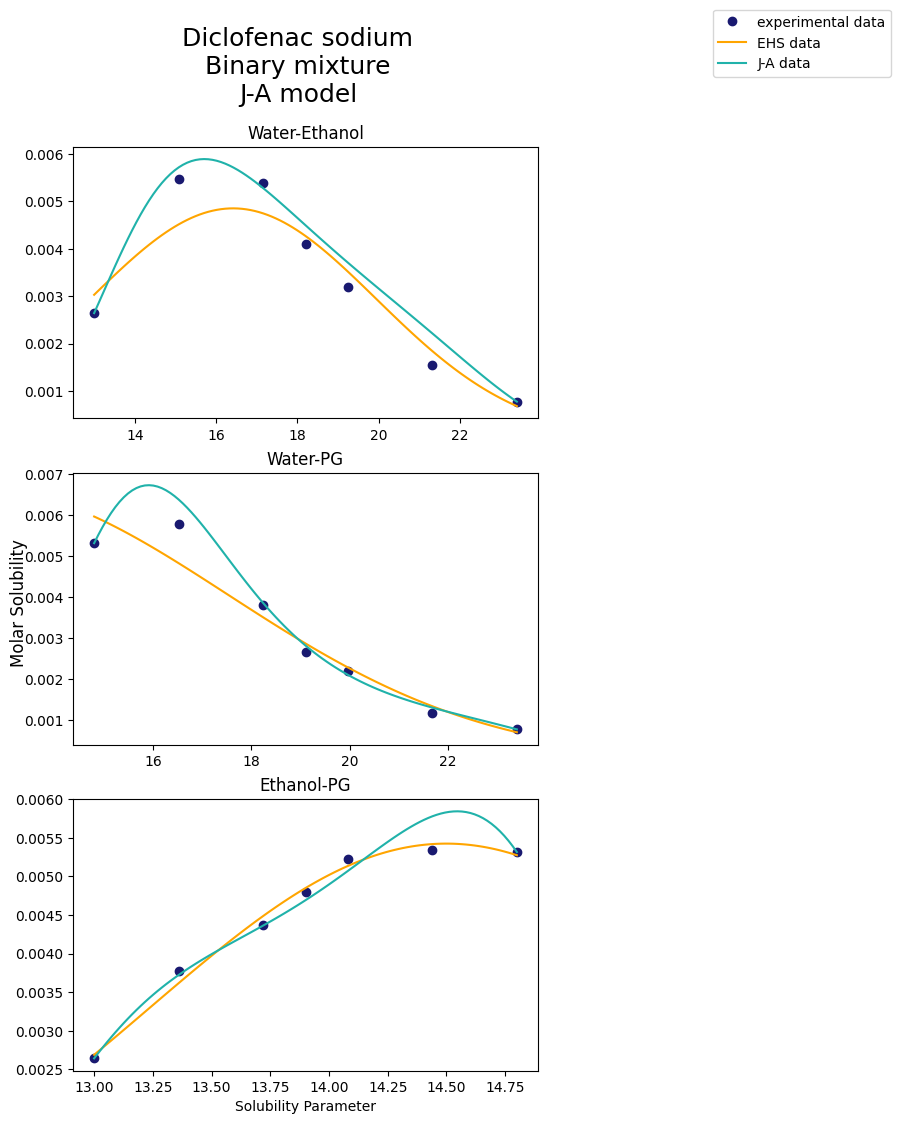

In [232]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=False , sharey=False, layout= None)
fig.suptitle('Diclofenac sodium'+ '\n' + 'Binary mixture'+ '\n' + 'J-A model' , fontsize = 18)
plt.xlabel("Solubility Parameter")

axs[0].set_title("Water-Ethanol")

axs[0].plot(spmix_WE, Cm_WE_T,"o", color= 'midnightblue' , label = "experimental data")
axs[0].plot(spmix2_WE, H_WE_T, color = 'orange' , label = "EHS data"  )
axs[0].plot(spmix2_WE, J_WE_T, color = 'lightseagreen'  , label = "J-A data", )


fig.legend( bbox_to_anchor=(1.5, 1))

axs[1].set_title("Water-PG")

axs[1].plot(spmix_WPG, Cm_WPG_T,"o", color= 'midnightblue' , label = "experimental data")
axs[1].plot(spmix2_WPG, H_WPG_T, color = 'orange' , label = "EHS data"  )
axs[1].plot(spmix2_WPG, J_WPG_T, color = 'lightseagreen'  , label = "J-A data", )


axs[2].set_title("Ethanol-PG")

axs[2].plot(spmix_EPG, Cm_EPG_T,"o", color= 'midnightblue' , label = "experimental data")
axs[2].plot(spmix2_EPG, H_EPG_T, color = 'orange' , label = "EHS data"  )
axs[2].plot(spmix2_EPG, J_EPG_T, color = 'lightseagreen'  , label = "J-A data", )


fig.supylabel("Molar Solubility")
#fig.supxlabel("Solubility Parameter")

plt.show()





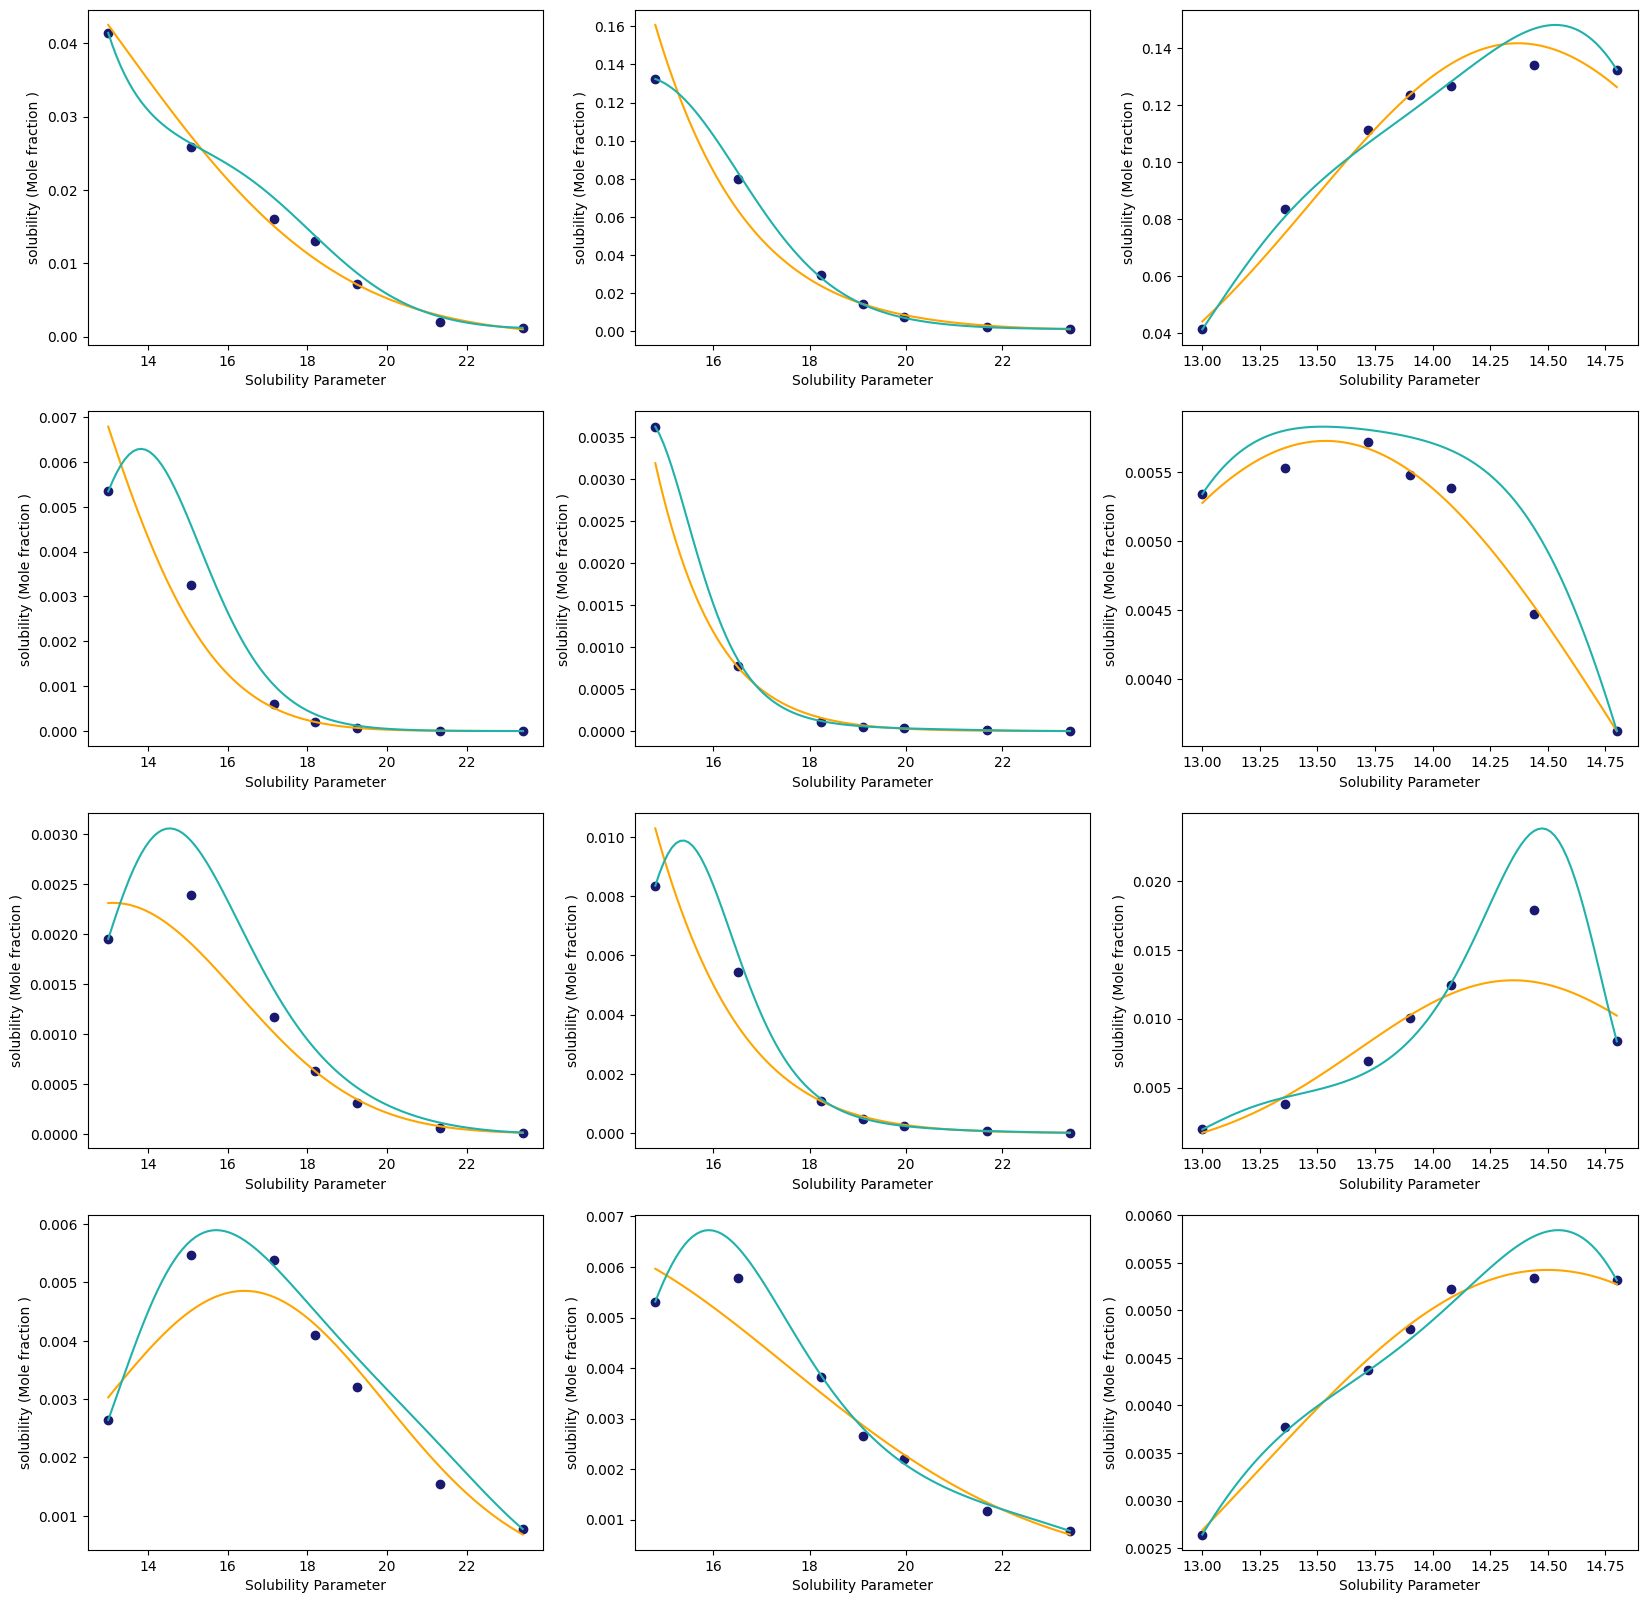

In [262]:
fig, axs = plt.subplots(4, 3, figsize=(20, 20), sharex=False , sharey=False, layout= None)



axs[0][0].plot(spmix_WE, Cm_WE_D,"o", color= 'midnightblue' , label = "experimental data")
axs[0][0].plot(spmix2_WE, H_WE_D, color = 'orange' , label = "EHS data"  )
axs[0][0].plot(spmix2_WE, J_WE_D, color = 'lightseagreen'  , label = "J-A data", )
axs[0][0].set_xlabel('Solubility Parameter')
axs[0][0].set_ylabel('solubility (Mole fraction )')
axs[0][1].plot(spmix_WPG, Cm_WPG_D,"o", color= 'midnightblue' , label = "experimental data")
axs[0][1].plot(spmix2_WPG, H_WPG_D, color = 'orange' , label = "EHS data"  )
axs[0][1].plot(spmix2_WPG, J_WPG_D, color = 'lightseagreen'  , label = "J-A data", )
axs[0][1].set_xlabel('Solubility Parameter')
axs[0][1].set_ylabel('solubility (Mole fraction )')
axs[0][2].plot(spmix_EPG, Cm_EPG_D,"o", color= 'midnightblue' , label = "experimental data")
axs[0][2].plot(spmix2_EPG, H_EPG_D, color = 'orange' , label = "EHS data"  )
axs[0][2].plot(spmix2_EPG, J_EPG_D, color = 'lightseagreen'  , label = "J-A data", )
axs[0][2].set_xlabel('Solubility Parameter')
axs[0][2].set_ylabel('solubility (Mole fraction )')

axs[1][0].plot(spmix_WE, Cm_WE_K,"o", color= 'midnightblue' , label = "experimental data")
axs[1][0].plot(spmix2_WE, H_WE_K, color = 'orange' , label = "EHS data"  )
axs[1][0].plot(spmix2_WE, J_WE_K, color = 'lightseagreen'  , label = "J-A data", )
axs[1][0].set_xlabel('Solubility Parameter')
axs[1][0].set_ylabel('solubility (Mole fraction )')
axs[1][1].plot(spmix_WPG, Cm_WPG_K,"o", color= 'midnightblue' , label = "experimental data")
axs[1][1].plot(spmix2_WPG, H_WPG_K, color = 'orange' , label = "EHS data"  )
axs[1][1].plot(spmix2_WPG, J_WPG_K, color = 'lightseagreen'  , label = "J-A data", )
axs[1][1].set_xlabel('Solubility Parameter')
axs[1][1].set_ylabel('solubility (Mole fraction )')
axs[1][2].plot(spmix_EPG, Cm_EPG_K,"o", color= 'midnightblue' , label = "experimental data")
axs[1][2].plot(spmix2_EPG, H_EPG_K, color = 'orange' , label = "EHS data"  )
axs[1][2].plot(spmix2_EPG, J_EPG_K, color = 'lightseagreen'  , label = "J-A data", )
axs[1][2].set_xlabel('Solubility Parameter')
axs[1][2].set_ylabel('solubility (Mole fraction )')



axs[2][0].plot(spmix_WE, Cm_WE_L,"o", color= 'midnightblue' , label = "experimental data")
axs[2][0].plot(spmix2_WE, H_WE_L, color = 'orange' , label = "EHS data"  )
axs[2][0].plot(spmix2_WE, J_WE_L, color = 'lightseagreen'  , label = "J-A data", )
axs[2][0].set_xlabel('Solubility Parameter')
axs[2][0].set_ylabel('solubility (Mole fraction )')
axs[2][1].plot(spmix_WPG, Cm_WPG_L,"o", color= 'midnightblue' , label = "experimental data")
axs[2][1].plot(spmix2_WPG, H_WPG_L, color = 'orange' , label = "EHS data"  )
axs[2][1].plot(spmix2_WPG, J_WPG_L, color = 'lightseagreen'  , label = "J-A data", )
axs[2][1].set_xlabel('Solubility Parameter')
axs[2][1].set_ylabel('solubility (Mole fraction )')
axs[2][2].plot(spmix_EPG, Cm_EPG_L,"o", color= 'midnightblue' , label = "experimental data")
axs[2][2].plot(spmix2_EPG, H_EPG_L, color = 'orange' , label = "EHS data"  )
axs[2][2].plot(spmix2_EPG, J_EPG_L, color = 'lightseagreen'  , label = "J-A data", )
axs[2][2].set_xlabel('Solubility Parameter')
axs[2][2].set_ylabel('solubility (Mole fraction )')



axs[3][0].plot(spmix_WE, Cm_WE_T,"o", color= 'midnightblue' , label = "experimental data")
axs[3][0].plot(spmix2_WE, H_WE_T, color = 'orange' , label = "EHS data"  )
axs[3][0].plot(spmix2_WE, J_WE_T, color = 'lightseagreen'  , label = "J-A data", )
axs[3][0].set_xlabel('Solubility Parameter')
axs[3][0].set_ylabel('solubility (Mole fraction )')
axs[3][1].plot(spmix_WPG, Cm_WPG_T,"o", color= 'midnightblue' , label = "experimental data")
axs[3][1].plot(spmix2_WPG, H_WPG_T, color = 'orange' , label = "EHS data"  )
axs[3][1].plot(spmix2_WPG, J_WPG_T, color = 'lightseagreen'  , label = "J-A data", )
axs[3][1].set_xlabel('Solubility Parameter')
axs[3][1].set_ylabel('solubility (Mole fraction )')
axs[3][2].plot(spmix_EPG, Cm_EPG_T,"o", color= 'midnightblue' , label = "experimental data")
axs[3][2].plot(spmix2_EPG, H_EPG_T, color = 'orange' , label = "EHS data"  )
axs[3][2].plot(spmix2_EPG, J_EPG_T, color = 'lightseagreen'  , label = "J-A data", )
axs[3][2].set_xlabel('Solubility Parameter')
axs[3][2].set_ylabel('solubility (Mole fraction )')


plt.savefig("binary.jpg", bbox_inches = 'tight', dpi = 1000)
